## Stop-signal dataset

This is based on the famous stop-signal dataset of Adam Aron and was fetched from openfmri.

See [ds008](https://openfmri.org/dataset/ds000008)

In [1]:
import stopsignal

In [2]:
import re

In [3]:
reg = re.compile('.*/sub-(?P<subj_idx>[0-9]+)/func/sub-[0-9]+_task-(?P<task>[a-z]+)_run-(?P<run>[0-9]+)_events.tsv')

In [4]:
import glob
import os

In [5]:
fns = glob.glob(os.path.join(os.environ['HOME'], 'data/openfmri/ds008/sub*/func/sub-*_task-stopsignal_run-*_events.tsv'))

In [6]:
import pandas

In [7]:
dfs = []

for fn in fns:
    d = reg.match(fn).groupdict()
    
    dfs.append(pandas.read_csv(fn, sep='\t', index_col=False,na_values=['n/a', 'junk']))
    dfs[-1]['subj_idx'] = d['subj_idx']
    dfs[-1]['run'] = d['run']
    
df = pandas.concat(dfs)

In [8]:
df = df[~df.response_time.isnull() & (~df.trial_type.isnull())]

In [9]:
df[(df.subj_idx == 14) & (df.trial_type == '')]

,CorrectGo,Response,SSD,Stimulus,SuccStop,TrialType,duration,onset,response_time,run,subj_idx,trial_type


In [10]:
df['rt'] = df['response_time'] * 1000.
df['ssd'] = (df['SSD']*1000)
df.loc[(df.trial_type == 'go'), 'ssd'] = -999
df['ssd'] = df.ssd.astype(int)
df['inhibited'] = df.trial_type.map({'go':-999, 'failed stop':0, 'successful stop':1})
df['ss_presented'] = df.trial_type.map({'go':0, 'failed stop':1, 'successful stop':1}).astype(int)

In [11]:
df.trial_type.unique()

array(['go', 'failed stop', 'successful stop'], dtype=object)

In [12]:
df = df[~((df.subj_idx == '14') & (df.rt > 500))]

In [15]:
import seaborn as sns
%matplotlib inline

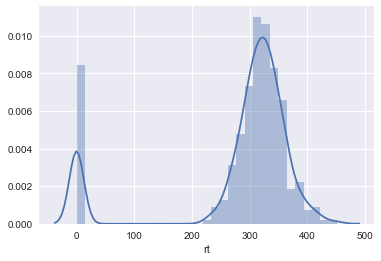

In [16]:
sns.distplot(df[(df.subj_idx == '14')].rt)

In [17]:
df[(df.subj_idx == '14')].groupby(['trial_type', 'inhibited', 'ss_presented']).size()

trial_type       inhibited  ss_presented
failed stop       0         1                49
go               -999       0               279
successful stop   1         1                46
dtype: int64

In [18]:
df.groupby(['subj_idx', 'trial_type']).ssd.min()

subj_idx  trial_type     
01        failed stop        150
          go                -999
          successful stop     50
02        failed stop        150
          go                -999
          successful stop    100
03        failed stop        250
          go                -999
          successful stop    100
04        failed stop        100
          go                -999
          successful stop     50
05        failed stop        200
          go                -999
          successful stop    100
06        failed stop        100
          go                -999
          successful stop     50
07        failed stop        100
          go                -999
          successful stop     50
09        failed stop        200
          go                -999
          successful stop    100
10        failed stop        150
          go                -999
          successful stop    100
11        failed stop        150
          go                -999
          success

In [19]:
df[(df.subj_idx == '14')][['rt', 'ssd', 'inhibited', 'ss_presented']].groupby(['ss_presented', 'inhibited']).mean()

rt         ssd
ss_presented inhibited                        
0            -999       324.734767 -999.000000
1             0         317.979592  167.346939
              1           0.000000  116.304348

In [20]:
model = stopsignal.StopSignal(df)

In [21]:
model.sample(10000)

/Users/gilles/anaconda3/envs/py27/lib/python2.7/site-packages/pymc/utils.py:435: RuntimeWarning: divide by zero encountered in log
  return np.where(y > 0, np.log(y), -np.inf)


 [-----------------100%-----------------] 10000 of 10000 complete in 902.1 sec

Plotting mu_go
Plotting mu_go_std
Plotting sigma_go
Plotting sigma_go_std
Plotting tau_go
Plotting tau_go_std
Plotting mu_stop
Plotting mu_stop_std
Plotting sigma_stop
Plotting sigma_stop_std
Plotting tau_stop
Plotting tau_stop_std


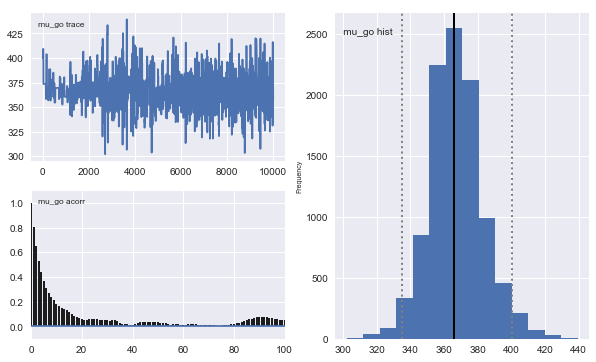

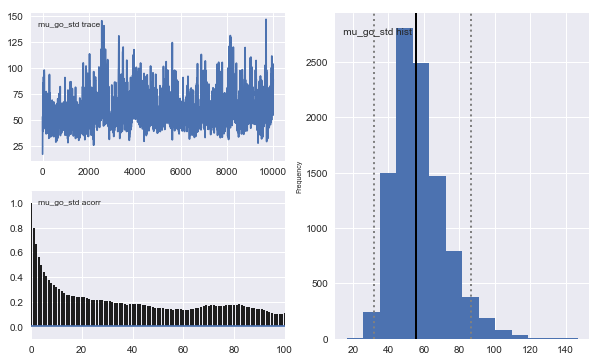

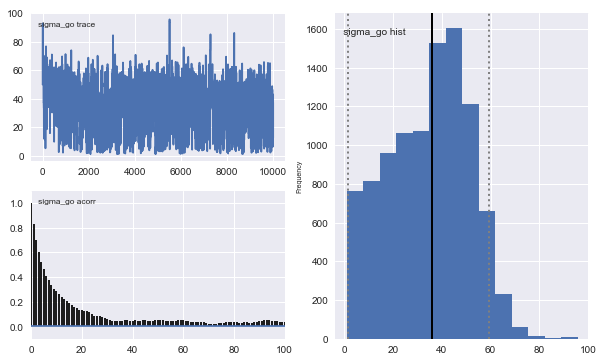

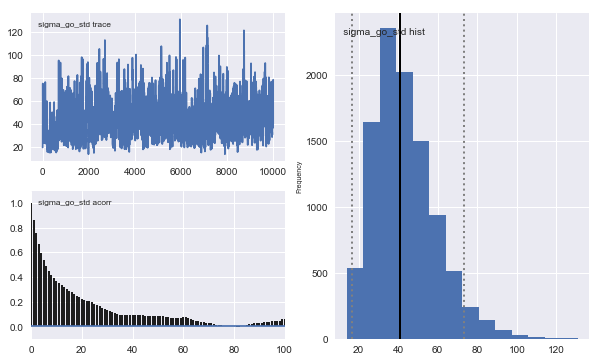

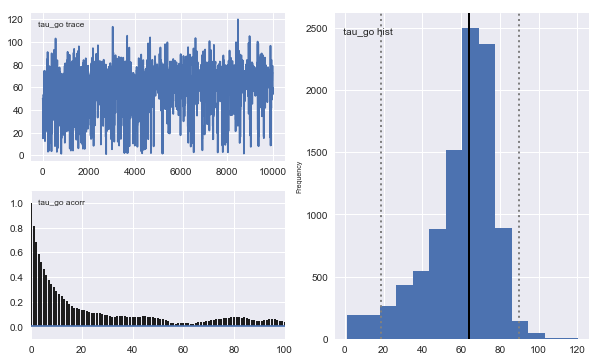

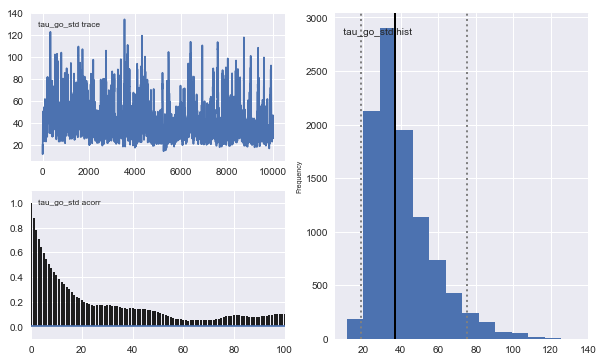

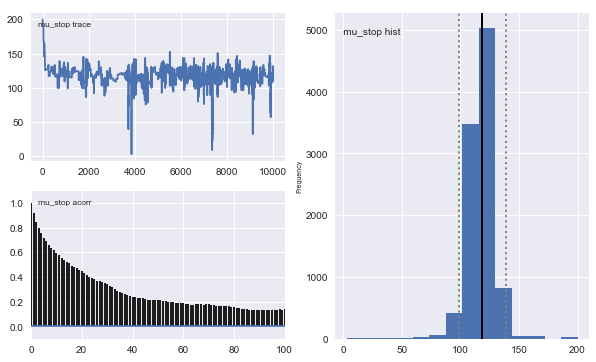

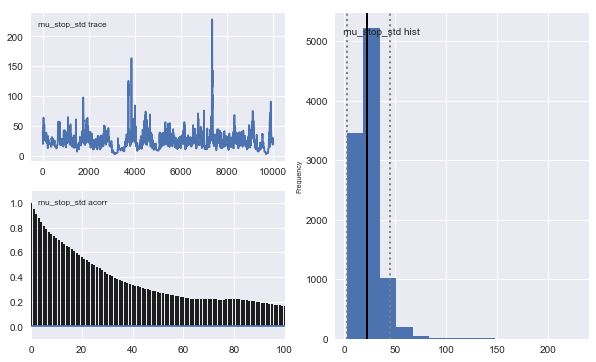

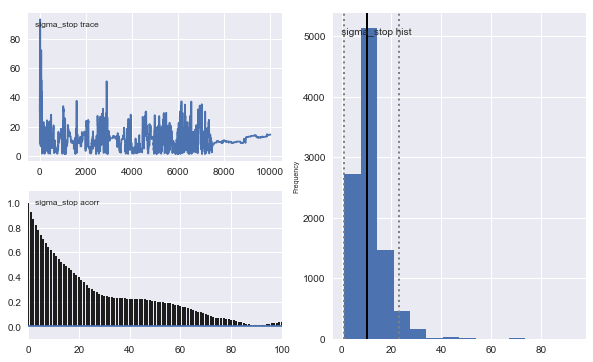

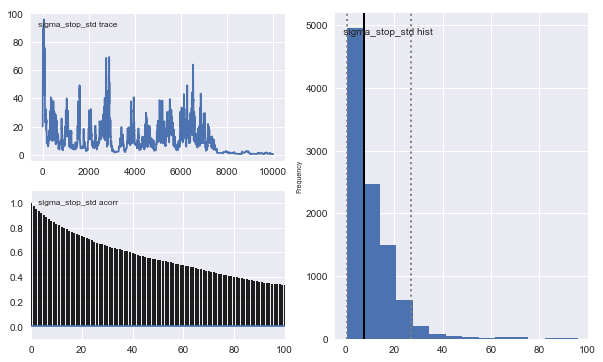

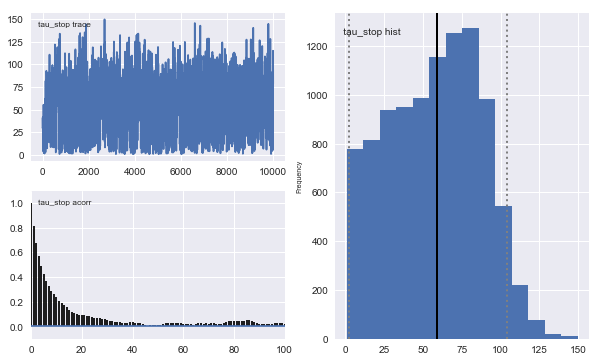

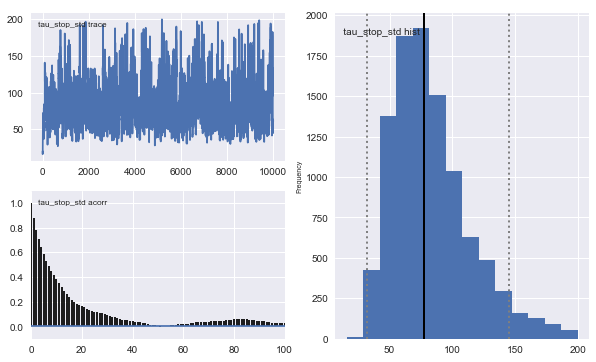

In [22]:
model.plot_posteriors()

In [24]:
subj_nodes = model.get_subj_nodes()
subj_nodes = subj_nodes[subj_nodes.knode_name == 'mu_stop_subj']
tmp = subj_nodes[['subj_idx', 'tag', 'node', 'mean']]

In [25]:
tmp.set_index('subj_idx')

,tag,node,mean
subj_idx,,,
01,(),mu_stop_subj.01,110.52
02,(),mu_stop_subj.02,109.683
03,(),mu_stop_subj.03,127.187
04,(),mu_stop_subj.04,97.9186
05,(),mu_stop_subj.05,127.529
06,(),mu_stop_subj.06,111.284
07,(),mu_stop_subj.07,150.946
09,(),mu_stop_subj.09,134.225
10,(),mu_stop_subj.10,91.639


In [26]:
tmp.to_csv('ssrts.csv')

In [27]:
subj_nodes = model.get_subj_nodes()
subj_nodes = subj_nodes[subj_nodes.knode_name == 'mu_go_subj']
tmp = subj_nodes[['subj_idx', 'tag', 'node', 'mean']]

In [28]:
tmp.to_csv('mu_go.csv')